In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface Erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\Python\Data Science\Road Damage\pothole_detection_CNN\Datasetv2',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1284 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

41

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 0 2 0 2 0 0 2 0 0 2 2 2 2 1 2 1 2 0 0 1 0 0 1 2 0 0 2 0 0 2 2]


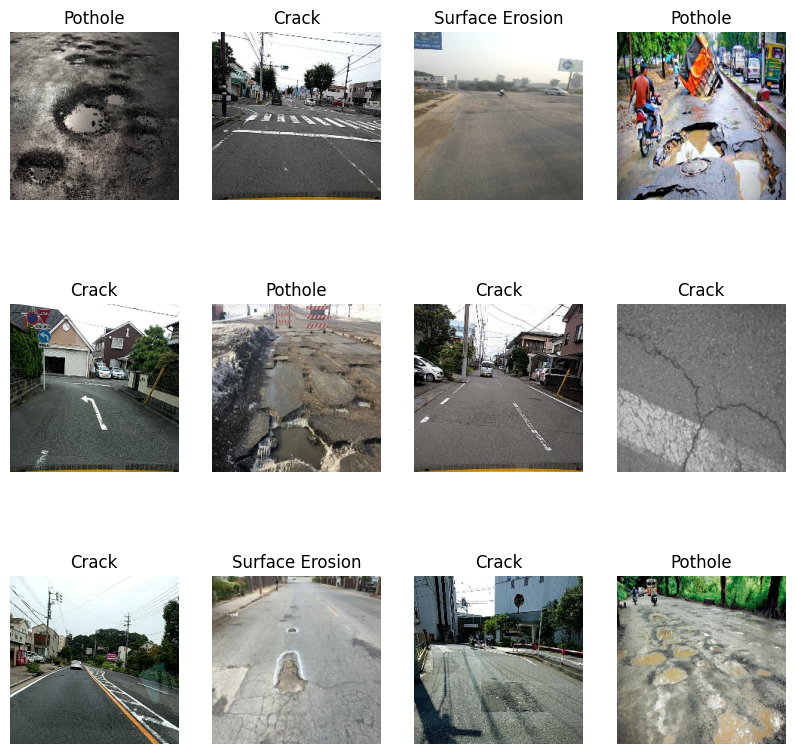

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    train_data = ds.take(train_size)
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data
train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 32
Validation data size: 4
Test data size: 5


In [9]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2)
])

In [12]:
def build_resnet50_model():
    base = tf.keras.applications.ResNet50(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [13]:
model = build_resnet50_model()

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.3881 - loss: 1.1769 - val_accuracy: 0.6328 - val_loss: 0.9230
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.5837 - loss: 0.9184 - val_accuracy: 0.5781 - val_loss: 0.9078
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.6106 - loss: 0.8733 - val_accuracy: 0.6406 - val_loss: 0.8486
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.5989 - loss: 0.8949 - val_accuracy: 0.6641 - val_loss: 0.8378
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.6267 - loss: 0.8651 - val_accuracy: 0.6250 - val_loss: 0.8702
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.6697 - loss: 0.8233 - val_accuracy: 0.6875 - val_loss: 0.8113
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.7008 - loss: 0.8023 - val_accuracy: 0.7109 - val_loss: 0.7860
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.6165 - loss: 0.8646 - val_accuracy: 0.7031 - val_loss

In [17]:
scores = model.evaluate(test_data)
scores

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6674 - loss: 0.7551


[0.7008035778999329, 0.699999988079071]

In [36]:
model.save("Trained Model/RESNETv1.o.h5")
model.save("Trained Model/RESNETv1.o.keras")

In [19]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 32}

In [20]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [21]:
history.history['accuracy']

[0.46385541558265686,
 0.5943775177001953,
 0.6174699068069458,
 0.6134538054466248,
 0.6395582556724548,
 0.6576305031776428,
 0.6907630562782288,
 0.6536144614219666,
 0.6887550354003906,
 0.6897590160369873,
 0.6907630562782288,
 0.6937751173973083,
 0.6887550354003906,
 0.6987951993942261,
 0.6957831382751465,
 0.6997991800308228,
 0.7058233022689819,
 0.7158634662628174,
 0.7148594260215759,
 0.7238956093788147,
 0.7379518151283264,
 0.7118473649024963,
 0.727911651134491,
 0.7289156913757324,
 0.7138554453849792,
 0.7048192620277405,
 0.6987951993942261,
 0.7389557957649231,
 0.7339357137680054,
 0.7319276928901672,
 0.7359437942504883,
 0.7259036302566528,
 0.718875527381897,
 0.7379518151283264,
 0.7138554453849792,
 0.7459839582443237,
 0.7319276928901672,
 0.7329317331314087,
 0.7309237122535706,
 0.7238956093788147,
 0.7439758777618408,
 0.7530120611190796,
 0.7389557957649231,
 0.7399598360061646,
 0.7319276928901672,
 0.7459839582443237,
 0.7339357137680054,
 0.74397587776

In [22]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
F1 Score (macro): 0.7036363636363636
F1 Score (weighted): 0.7098295454545454

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.91      0.75      0.82        55
        Pothole       0.75      0.67      0.71        58
Surface Erosion       0.51      0.68      0.58        47

       accuracy                           0.70       160
      macro avg       0.72      0.70      0.70       160
   weighted avg       0.73      0.70      0.71       160



In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

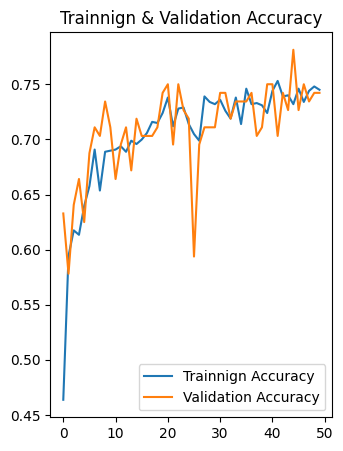

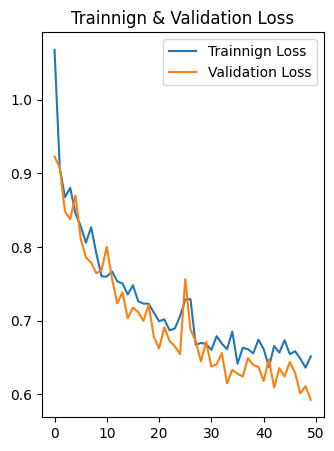

In [31]:

plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,5))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [25]:
model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7437 - loss: 0.6461


[0.7008035778999329, 0.699999988079071]

First image to predict
First image actual label:  Pothole
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label:  Pothole


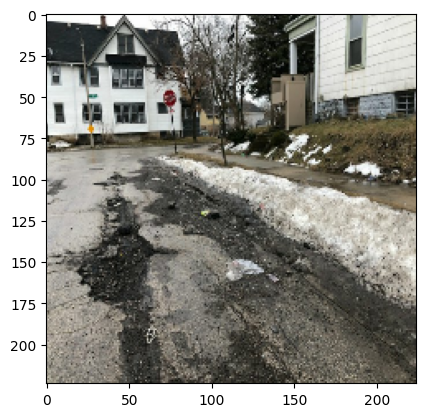

In [26]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->49.86000061035156 Light:-> Normal lighting
Confidence:->59.849998474121094 Light:-> Low light
Confidence:->72.58999633789062 Light:-> Normal lighting
Confidence:->82.2300033569336 Light:-> Normal lighting
Confidence:->99.9800033569336 Light:-> Normal lighting
Confidence:->91.22000122070312 Light:-> Normal lighting
Confidence:->45.369998931884766 Light:-> Low light
Confidence:->65.2699966430664 Light:-> Normal lighting
Confidence:->36.459999084472656 Light:-> Normal lighting


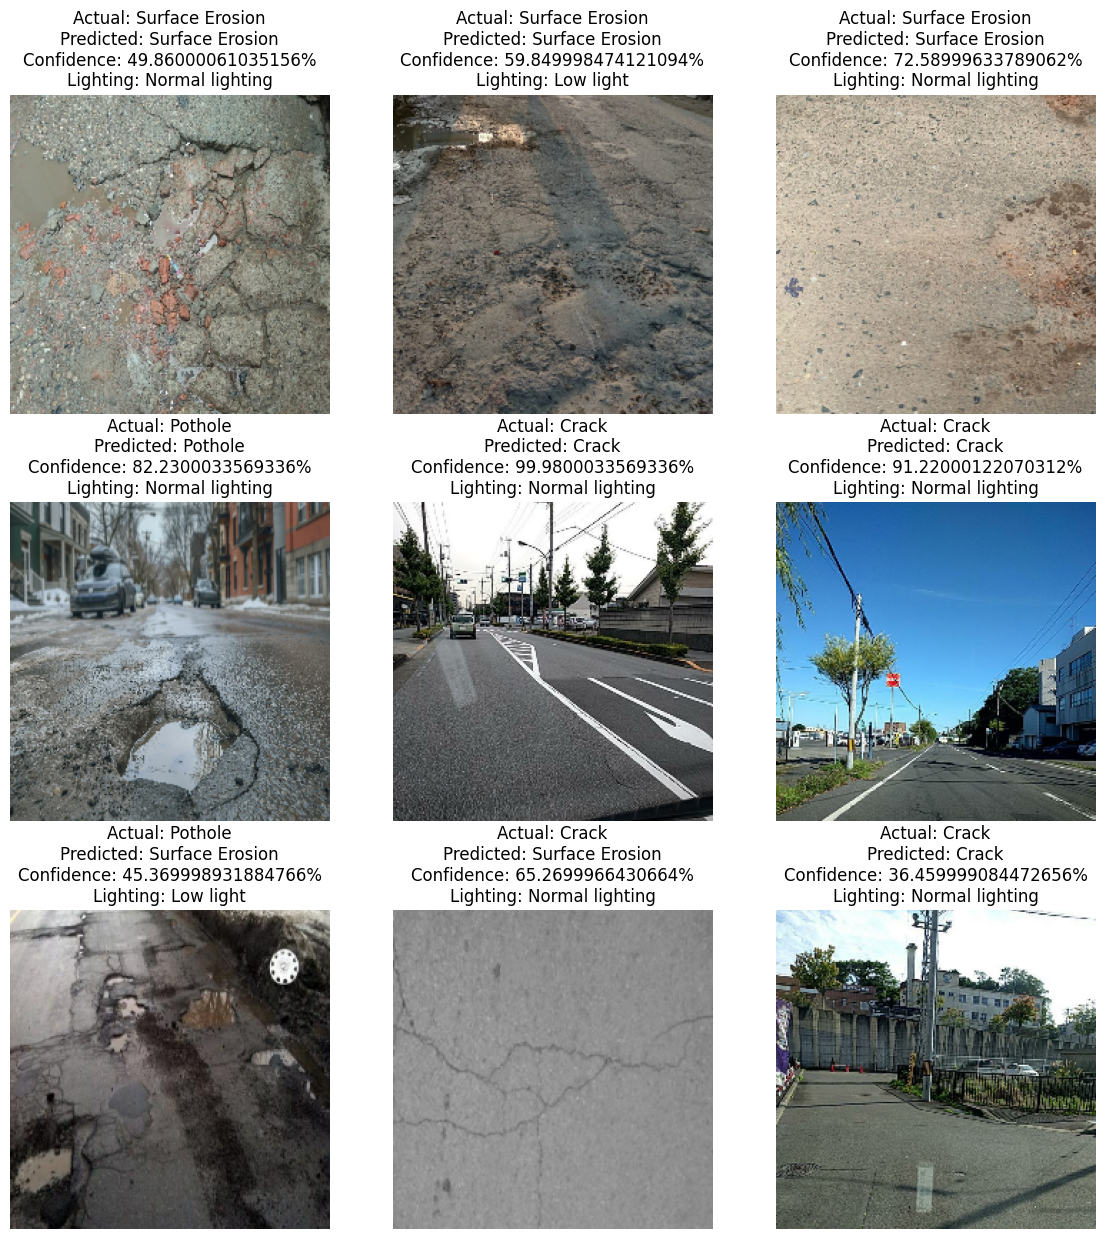

In [28]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [29]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Crack, Confidence: 36.459999084472656


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


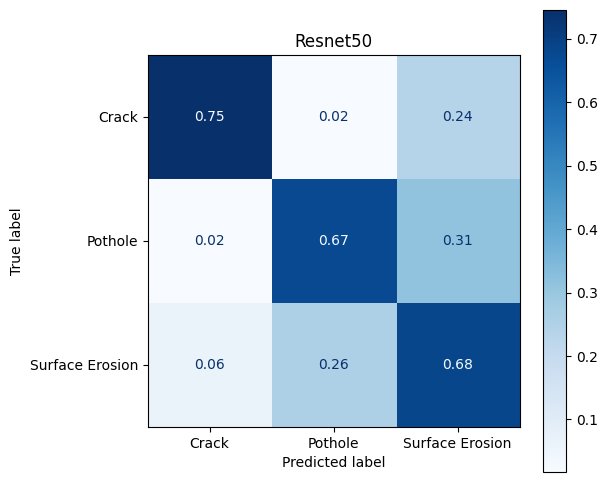

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)

    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("Resnet50")
plt.savefig("Confusion Matrx/Resnet50.png", dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


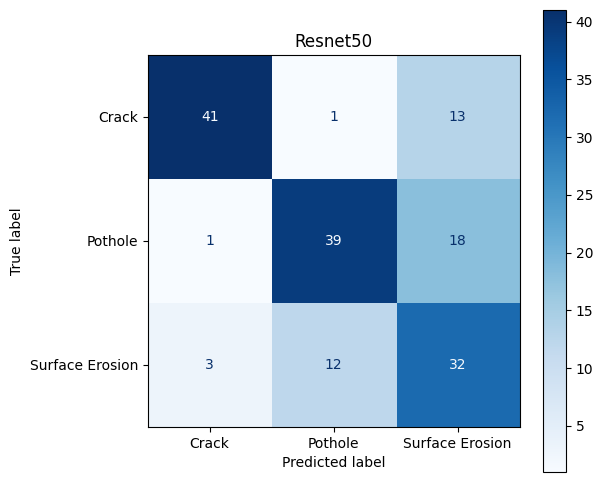

In [35]:
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute raw confusion matrix (actual counts)
cm = confusion_matrix(y_true, y_pred)

# Plot raw confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")  # "d" for integer values
plt.title("Resnet50")
plt.savefig("Confusion Matrx/Resnet50_counts.png", dpi=300, bbox_inches='tight')
plt.show()